# Inter-subject functional connectivity (ISFC)

In [1]:
import os
os.chdir ('/project/3013104.01/')
os.getcwd()

'/project/3013104.01'

## Define ISFC functions

In [4]:
import numpy as np
import numpy.ma as ma

def isfc_mod(data, method="average"):
    """
    *This function is a modified version of nltools.stats.isfc, ignoring NA values through masking. (CGDamatac)*

    
    Compute intersubject functional connectivity (ISFC) from a list of observation x feature matrices
    
    This function is a modified version which masks NA values.

    This function uses the leave one out approach to compute ISFC (Simony et al., 2016).
    For each subject, compute the cross-correlation between each ROI
    with the average of the rest of the subjects' data. In other words,
    compute the mean voxel/ROI response for all participants except the
    target subject. Then compute the correlation between each ROI within
    the target subject with the mean ROI response in the group average.

    Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016).
    Dynamic reconfiguration of the default mode network during narrative comprehension.
    Nature communications, 7, 12141.
    
    Args:
        data: list of subject matrices (observations x voxels/rois)
        method: approach to computing ISFC. 'average' uses leave one

    Returns:
        list of subject ISFC matrices

    """
    subjects = np.arange(len(data))

    if method == "average":
        sub_isfc = []
        for target in subjects:
            m1 = data[target]
            sub_mean = np.nanmean(np.stack([data[y] for y in subjects if y != target], axis=0), axis=0)

            # Print statements to check sub_mean values
            #print(f"Target Subject: {target}")
            #print("Sub Mean Before Division:", sub_mean)
            #print("Sub Mean After Division:", sub_mean)
            
            # Calculate the correlation between m1 and sub_mean, ignoring NA values
            sub_isfc.append(
                _compute_matrix_correlation_ignore_na(m1, sub_mean / (len(subjects) - 1))
            )
    else:
        raise NotImplementedError(
            "Only average method is implemented. Pairwise will be added at some point."
        )
    return sub_isfc

def _compute_matrix_correlation_ignore_na(matrix1, matrix2):
    """Computes the intersubject functional correlation between 2 matrices (observation x feature) while ignoring NA values"""
    
    # Mask NaN values in both input matrices
    masked_matrix1 = ma.masked_where(np.isnan(matrix1), matrix1)
    masked_matrix2 = ma.masked_where(np.isnan(matrix2), matrix2)
    
    # Calculate Pearson correlation coefficient between two masked arrays
    correlation_matrix = np.ma.corrcoef(masked_matrix1, masked_matrix2, rowvar=False)
    
    # Print the correlation matrix
    #print("Correlation matrix:")
    #print(correlation_matrix)
    
    return correlation_matrix

    # Example usage:
    # correlation_matrix = _compute_matrix_correlation_ignore_na(matrix1, matrix2)

## Calculate ROI level ISFC 
Use ROI ISFCs to generate network-level ISFC: Average the correlations across ROI pairs, resulting in a network-by-network connectivity matrix for all within and between network connections

In [5]:
import os
import shutil
import numpy as np
import pandas as pd

levels = ['roi_node'] 
conditions = ['neutral', 'threat'] 

for level in levels:
    for condition in conditions:
        data_dir = f'analysis/aural_framing_by_movie_topic/z_{level}/data/concatenated/{condition}'
        out_dir = f'analysis/inter-subject_functional_connectivity/z_{level}/{condition}'

        # Remove out_dir if it exists, and then create it
        if os.path.exists(out_dir):
            shutil.rmtree(out_dir)
        os.makedirs(out_dir)

        print(f"Processing {level} - {condition}")

        # List all subject CSV files in the data directory
        subject_files = os.listdir(data_dir)
        #subject_files = ['subject-0008_z_concat.csv', 'subject-0022_z_concat.csv']
        subject_files.sort()

        # Create a list to store all subjects' data matrices
        all_subject_data = []

        # Iterate through each subject
        for i, subject_file in enumerate(subject_files):
            print(f"Processing {subject_file}")
            #print(f"Shape of subject data for {subject_file}: {subject_data.values.shape}")
            #print(f"NaN values in subject data for {subject_file}: {np.isnan(subject_data.values).sum()}")

            # Read the data for the target subject
            subject_data = pd.read_csv(os.path.join(data_dir, subject_file), header=0, index_col=None, usecols=lambda col: col.lower() != 'volume')

            # Append the subject's data matrix to the list
            all_subject_data.append(subject_data.values)

        # Calculate ISFC for all subjects using the "average" method
        all_subject_isfc = isfc_mod(all_subject_data, method="average") # this takes a long time
        #print(f"Shape of ISFC for {subject_file}: {subject_isfc.shape}")

        # Iterate through each subject's ISFC result
        for i, subject_isfc in enumerate(all_subject_isfc):
            
            # Extract the subject name from the input filename
            subject_name = subject_files[i].split('_')[0]

            # Save the ISFC result for this subject as a CSV file
            output_filename = f'{subject_name}_isfc.csv'

            # Determine the number of rows and columns based on the level
            if level == 'network':
                num_rows_columns = 7  # For the 'network' level
            elif level == 'roi_node':
                num_rows_columns = 300  # For the 'roi_node' level

            # Create a DataFrame from the ISFC matrix with integer labels
            isfc_df = pd.DataFrame(subject_isfc[:num_rows_columns, :num_rows_columns], columns=range(num_rows_columns), index=range(num_rows_columns))

            # Save the DataFrame to a CSV file in the output directory
            isfc_df.to_csv(os.path.join(out_dir, output_filename))

            print(f"Saved ISFC result for {subject_name}")

        print("Finished processing all subjects.")
        print(f"Saved ISFC results as CSV files in {out_dir}")


Processing roi_node - neutral
Processing subject-0001_z_concat.csv
Processing subject-0003_z_concat.csv
Processing subject-0004_z_concat.csv
Processing subject-0005_z_concat.csv
Processing subject-0006_z_concat.csv
Processing subject-0007_z_concat.csv
Processing subject-0008_z_concat.csv
Processing subject-0009_z_concat.csv
Processing subject-0010_z_concat.csv
Processing subject-0011_z_concat.csv
Processing subject-0012_z_concat.csv
Processing subject-0013_z_concat.csv
Processing subject-0014_z_concat.csv
Processing subject-0015_z_concat.csv
Processing subject-0016_z_concat.csv
Processing subject-0017_z_concat.csv
Processing subject-0018_z_concat.csv
Processing subject-0019_z_concat.csv
Processing subject-0020_z_concat.csv
Processing subject-0021_z_concat.csv
Processing subject-0022_z_concat.csv
Processing subject-0023_z_concat.csv
Processing subject-0024_z_concat.csv
Processing subject-0025_z_concat.csv
Processing subject-0026_z_concat.csv
Processing subject-0027_z_concat.csv
Processi

Processing subject-0224_z_concat.csv
Processing subject-0225_z_concat.csv
Processing subject-0226_z_concat.csv
Processing subject-0227_z_concat.csv
Processing subject-0228_z_concat.csv
Processing subject-0229_z_concat.csv
Processing subject-0230_z_concat.csv
Processing subject-0231_z_concat.csv
Processing subject-0232_z_concat.csv
Processing subject-0233_z_concat.csv
Processing subject-0234_z_concat.csv
Processing subject-0235_z_concat.csv
Processing subject-0236_z_concat.csv
Processing subject-0237_z_concat.csv
Processing subject-0238_z_concat.csv
Processing subject-0239_z_concat.csv
Saved ISFC result for subject-0001
Saved ISFC result for subject-0003
Saved ISFC result for subject-0004
Saved ISFC result for subject-0005
Saved ISFC result for subject-0006
Saved ISFC result for subject-0007
Saved ISFC result for subject-0008
Saved ISFC result for subject-0009
Saved ISFC result for subject-0010
Saved ISFC result for subject-0011
Saved ISFC result for subject-0012
Saved ISFC result for s

Saved ISFC result for subject-0220
Saved ISFC result for subject-0221
Saved ISFC result for subject-0222
Saved ISFC result for subject-0223
Saved ISFC result for subject-0224
Saved ISFC result for subject-0225
Saved ISFC result for subject-0226
Saved ISFC result for subject-0227
Saved ISFC result for subject-0228
Saved ISFC result for subject-0229
Saved ISFC result for subject-0230
Saved ISFC result for subject-0231
Saved ISFC result for subject-0232
Saved ISFC result for subject-0233
Saved ISFC result for subject-0234
Saved ISFC result for subject-0235
Saved ISFC result for subject-0236
Saved ISFC result for subject-0237
Saved ISFC result for subject-0238
Saved ISFC result for subject-0239
Finished processing all subjects.
Saved ISFC results as CSV files in analysis/inter-subject_functional_connectivity/z_roi_node/neutral
Processing roi_node - threat
Processing subject-0001_z_concat.csv
Processing subject-0003_z_concat.csv
Processing subject-0004_z_concat.csv
Processing subject-0005_z

Processing subject-0207_z_concat.csv
Processing subject-0208_z_concat.csv
Processing subject-0209_z_concat.csv
Processing subject-0210_z_concat.csv
Processing subject-0211_z_concat.csv
Processing subject-0212_z_concat.csv
Processing subject-0213_z_concat.csv
Processing subject-0214_z_concat.csv
Processing subject-0215_z_concat.csv
Processing subject-0216_z_concat.csv
Processing subject-0217_z_concat.csv
Processing subject-0218_z_concat.csv
Processing subject-0219_z_concat.csv
Processing subject-0220_z_concat.csv
Processing subject-0221_z_concat.csv
Processing subject-0222_z_concat.csv
Processing subject-0223_z_concat.csv
Processing subject-0224_z_concat.csv
Processing subject-0225_z_concat.csv
Processing subject-0226_z_concat.csv
Processing subject-0227_z_concat.csv
Processing subject-0228_z_concat.csv
Processing subject-0229_z_concat.csv
Processing subject-0230_z_concat.csv
Processing subject-0231_z_concat.csv
Processing subject-0232_z_concat.csv
Processing subject-0233_z_concat.csv
P

Saved ISFC result for subject-0202
Saved ISFC result for subject-0203
Saved ISFC result for subject-0204
Saved ISFC result for subject-0205
Saved ISFC result for subject-0206
Saved ISFC result for subject-0207
Saved ISFC result for subject-0208
Saved ISFC result for subject-0209
Saved ISFC result for subject-0210
Saved ISFC result for subject-0211
Saved ISFC result for subject-0212
Saved ISFC result for subject-0213
Saved ISFC result for subject-0214
Saved ISFC result for subject-0215
Saved ISFC result for subject-0216
Saved ISFC result for subject-0217
Saved ISFC result for subject-0218
Saved ISFC result for subject-0219
Saved ISFC result for subject-0220
Saved ISFC result for subject-0221
Saved ISFC result for subject-0222
Saved ISFC result for subject-0223
Saved ISFC result for subject-0224
Saved ISFC result for subject-0225
Saved ISFC result for subject-0226
Saved ISFC result for subject-0227
Saved ISFC result for subject-0228
Saved ISFC result for subject-0229
Saved ISFC result fo

In [17]:
# troubleshooting
zero_variance_columns = np.where(np.var(all_subject_data[0], axis=0) == 0)[0]
print("Zero variance columns:", zero_variance_columns)
print("Infinite values in matrix1:", np.sum(np.isinf(all_subject_data[0])))
print("Infinite values in matrix2:", np.sum(np.isinf(all_subject_data[0])) if len(all_subject_data) > 0 else 0)
print("Subject data:")
print(subject_data)


Zero variance columns: []
Infinite values in matrix1: 0
Infinite values in matrix2: 0
Subject data:
          0.0       1.0       2.0       3.0       4.0       5.0       6.0  \
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10        NaN       NaN       NaN       NaN       NaN

## Plot heatmap of ROI-level ISFCs

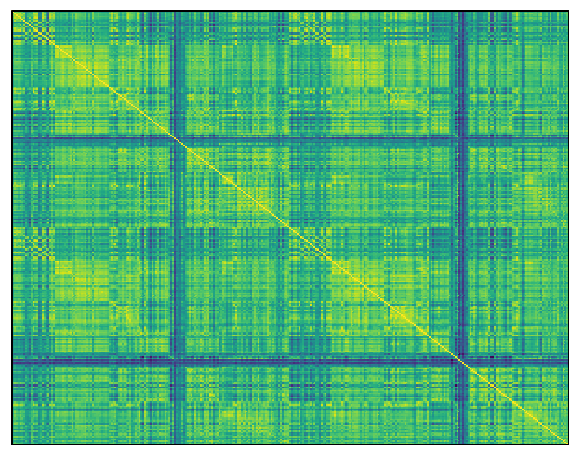

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('analysis/inter-subject_functional_connectivity/z_roi_node/neutral/subject-0001_isfc.csv', header=0, index_col=0)
plt.figure(figsize=(10, 8))  # Set the figure size
ax = sns.heatmap(data, cmap='viridis', cbar=False)  #
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.hlines([0, data.shape[0]], 0, data.shape[1], colors='black', linewidth=3)  
ax.vlines([0, data.shape[1]], 0, data.shape[0], colors='black', linewidth=3)  
plt.show()

# Between-network ISFC ~ SPSQ dimension score

## Pick nodes in a priori networks

In [31]:
import pandas as pd

# Load the DataFrame from the CSV file
node_network_key = pd.read_csv('analysis/atlas_schaefer/label_network.csv', header=0)

# List of target networks
networks = ['salience_ventral_attention', 'control', 'default']

# Create a dictionary to store nodes for each network
network_nodes = {}

# Iterate over the target networks and filter nodes for each
for network in networks:
    filtered_nodes = node_network_key[node_network_key['network'] == network]
    nodes_in_network = filtered_nodes['node'].tolist()
    network_nodes[network] = nodes_in_network

# Print the lists of nodes for each network
for network, nodes_list in network_nodes.items():
    print(f'Nodes in network "{network}":')
    print(nodes_list)


Nodes in network "salience_ventral_attention":
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236]
Nodes in network "control":
[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269]
Nodes in network "default":
[112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]


## Average across between network-pairs of ROIs

In [12]:
import os
import pandas as pd
import numpy as np

# List of conditions to loop through
conditions = ['neutral', 'threat']

# Specify the networks you want to analyze
networks = ['control', 'default', 'salience_ventral_attention']

for condition in conditions:
    data_dir = f'analysis/inter-subject_functional_connectivity/z_roi_node/{condition}'
    out_dir = f'analysis/inter-subject_functional_connectivity/network/{condition}'

    # Create the output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Iterate over subject matrix files
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            # Load the subject's functional connectivity matrix
            connectivity_matrix = pd.read_csv(os.path.join(data_dir, filename), header=0, index_col=0)

            # Remove the '.0' from the header and index column values as strings
            connectivity_matrix.columns = connectivity_matrix.columns.astype(str).str.replace(r'\.0$', '')
            connectivity_matrix.index = connectivity_matrix.index.astype(str).str.replace(r'\.0$', '')

            # Create an empty network connectivity matrix
            network_matrix = pd.DataFrame(index=networks, columns=networks)

            # Iterate over network combinations
            for i in range(len(networks)):
                for j in range(i, len(networks)):
                    network_i = networks[i]
                    network_j = networks[j]
                    nodes_i = network_nodes.get(network_i, [])
                    nodes_j = network_nodes.get(network_j, [])
                    nodes_i = [str(node) for node in nodes_i]
                    nodes_j = [str(node) for node in nodes_j]

                    # Calculate the mean of all i_j for nodes in network_i and network_j
                    mean_ij = connectivity_matrix.loc[nodes_i, nodes_j].mean().mean()

                    # Store the mean in the network connectivity matrix
                    network_matrix.at[network_i, network_j] = mean_ij
                    network_matrix.at[network_j, network_i] = mean_ij  # Symmetric, so we mirror it

            # Save the network connectivity matrix to a CSV file
            output_filename = os.path.splitext(filename)[0] + '_network_connectivity_matrix.csv'
            network_matrix.to_csv(os.path.join(out_dir, output_filename), index=True, header=True)

## Plot a matrix

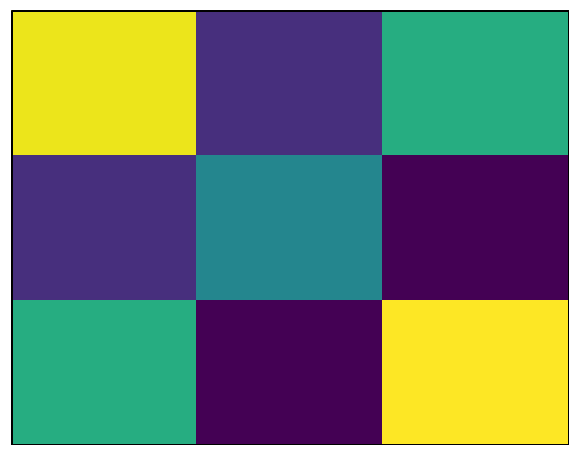

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('analysis/inter-subject_functional_connectivity/network/all/subject-0001_isfc_network_connectivity_matrix.csv', header=0, index_col=0)
plt.figure(figsize=(10, 8))  # Set the figure size
ax = sns.heatmap(data, cmap='viridis', cbar=False)  #
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.hlines([0, data.shape[0]], 0, data.shape[1], colors='black', linewidth=3)  
ax.vlines([0, data.shape[1]], 0, data.shape[0], colors='black', linewidth=3)  
plt.show()

## Vectorize ISFCs and merge with SPS data

In [15]:
import os
import pandas as pd
import numpy as np

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to vectorize connectivities
def vectorize_matrix(df, condition, subject_id):
    vectorized_data = df.values[np.tril_indices(df.shape[0], k=-1)]
    n = len(df.columns)
    network_pairs = [f'{df.columns[i]}-{df.columns[j]}' for i in range(n) for j in range(i + 1, n)]

    # Reshape the vectorized data to match the network pairs
    vectorized_data = vectorized_data.reshape(1, -1)

    # Create a DataFrame with the subject_id as the first column and network pairs as columns
    vectorized_df = pd.DataFrame(vectorized_data, columns=network_pairs)
    
    # Add 'subject' column with the subject_id
    vectorized_df.insert(0, 'subject', subject_id)
    
    return vectorized_df

# Function to process data for specific level and condition
def process_data(level, condition):
    data_dir = f'analysis/inter-subject_functional_connectivity/{level}/{condition}'
    out_dir = os.path.join(data_dir, 'vectorized')

    create_directory(out_dir)

    subject_matrices = [file for file in os.listdir(data_dir) if file.endswith('.csv')]

    all_vectorized_data = []

    for subject_matrix_file in subject_matrices:
        input_file = os.path.join(data_dir, subject_matrix_file)

        # Extract the subject ID from the filename (before the first '_')
        subject_id = subject_matrix_file.split('_')[0]

        df = pd.read_csv(input_file, header=0, index_col=0)
        
        # Vectorize connectivities
        vectorized_df = vectorize_matrix(df, condition, subject_id)
        
        output_file = os.path.join(out_dir, f'vectorized_{subject_id}.csv')  # Update the output filename
        vectorized_df.to_csv(output_file, index=False)  # No need to include the index

        print(f'Saved vectorized data for {subject_matrix_file} in {output_file}')
        all_vectorized_data.append(vectorized_df)

    
    # Concatenate connectivity vectors across subjects                                                                                                   
    concatenated_df = pd.concat(all_vectorized_data, ignore_index=True)

    concatenated_out_dir = os.path.join(out_dir, 'concatenated_data')
    create_directory(concatenated_out_dir)

    concatenated_output_file = os.path.join(concatenated_out_dir, f'concatenated_{condition}_data.csv')
    concatenated_df.to_csv(concatenated_output_file, index=False)

    print(f'Saved concatenated data for {condition} to {concatenated_output_file}')

    # Merge connectivity data with SPSQ data
    spsq_data_file = 'analysis/SPSQ-24_all.csv'
    spsq_df = pd.read_csv(spsq_data_file)

    concatenated_data_file = os.path.join(concatenated_out_dir, f'concatenated_{condition}_data.csv')
    concatenated_df = pd.read_csv(concatenated_data_file)

    merged_df = pd.merge(concatenated_df, spsq_df, on='subject', how='inner')

    merged_out_dir = os.path.dirname(concatenated_data_file)
    create_directory(merged_out_dir)

    merged_output_file = os.path.join(merged_out_dir, f'merged_{condition}_data.csv')
    merged_df.to_csv(merged_output_file, index=False)

    print(f'Saved merged data for {condition} to {merged_output_file}')

# Main function
def main():
    levels = ['network']
    conditions = ['neutral', 'threat']

    for level in levels:
        for condition in conditions:
            process_data(level, condition)

if __name__ == "__main__":
    main()


Saved vectorized data for subject-0001_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0001.csv
Saved vectorized data for subject-0003_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0003.csv
Saved vectorized data for subject-0004_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0004.csv
Saved vectorized data for subject-0005_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0005.csv
Saved vectorized data for subject-0006_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0006.csv
Saved vectorized data for subject-0007_isfc_network_connectivity_matrix.csv in analysis/inter-s

Saved vectorized data for subject-0058_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0058.csv
Saved vectorized data for subject-0059_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0059.csv
Saved vectorized data for subject-0060_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0060.csv
Saved vectorized data for subject-0061_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0061.csv
Saved vectorized data for subject-0062_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0062.csv
Saved vectorized data for subject-0063_isfc_network_connectivity_matrix.csv in analysis/inter-s

Saved vectorized data for subject-0132_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0132.csv
Saved vectorized data for subject-0133_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0133.csv
Saved vectorized data for subject-0134_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0134.csv
Saved vectorized data for subject-0135_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0135.csv
Saved vectorized data for subject-0136_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0136.csv
Saved vectorized data for subject-0137_isfc_network_connectivity_matrix.csv in analysis/inter-s

Saved vectorized data for subject-0189_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0189.csv
Saved vectorized data for subject-0190_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0190.csv
Saved vectorized data for subject-0191_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0191.csv
Saved vectorized data for subject-0192_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0192.csv
Saved vectorized data for subject-0193_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/neutral/vectorized/vectorized_subject-0193.csv
Saved vectorized data for subject-0194_isfc_network_connectivity_matrix.csv in analysis/inter-s

Saved merged data for neutral to analysis/inter-subject_functional_connectivity/network/neutral/vectorized/concatenated_data/merged_neutral_data.csv
Saved vectorized data for subject-0001_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0001.csv
Saved vectorized data for subject-0003_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0003.csv
Saved vectorized data for subject-0004_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0004.csv
Saved vectorized data for subject-0005_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0005.csv
Saved vectorized data for subject-0006_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/netwo

Saved vectorized data for subject-0050_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0050.csv
Saved vectorized data for subject-0051_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0051.csv
Saved vectorized data for subject-0052_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0052.csv
Saved vectorized data for subject-0053_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0053.csv
Saved vectorized data for subject-0054_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0054.csv
Saved vectorized data for subject-0055_isfc_network_connectivity_matrix.csv in analysis/inter-subjec

Saved vectorized data for subject-0105_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0105.csv
Saved vectorized data for subject-0106_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0106.csv
Saved vectorized data for subject-0107_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0107.csv
Saved vectorized data for subject-0108_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0108.csv
Saved vectorized data for subject-0109_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0109.csv
Saved vectorized data for subject-0110_isfc_network_connectivity_matrix.csv in analysis/inter-subjec

Saved vectorized data for subject-0158_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0158.csv
Saved vectorized data for subject-0159_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0159.csv
Saved vectorized data for subject-0160_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0160.csv
Saved vectorized data for subject-0161_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0161.csv
Saved vectorized data for subject-0162_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0162.csv
Saved vectorized data for subject-0163_isfc_network_connectivity_matrix.csv in analysis/inter-subjec

Saved vectorized data for subject-0216_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0216.csv
Saved vectorized data for subject-0217_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0217.csv
Saved vectorized data for subject-0218_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0218.csv
Saved vectorized data for subject-0219_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0219.csv
Saved vectorized data for subject-0220_isfc_network_connectivity_matrix.csv in analysis/inter-subject_functional_connectivity/network/threat/vectorized/vectorized_subject-0220.csv
Saved vectorized data for subject-0221_isfc_network_connectivity_matrix.csv in analysis/inter-subjec

### Plot a histogram of the ISFCs between networks

## Calculate mean between network ISFC across subjects

In [18]:
import pandas as pd
import os

out_dir = 'analysis/inter-subject_functional_connectivity/network/between/mean_results_all'

# Define conditions and columns_to_plot
conditions = ['neutral', 'threat']
networks = ['control-default', 'control-salience_ventral_attention', 'default-salience_ventral_attention']

for condition in conditions:
    # Create an empty DataFrame to store the concatenated results
    concatenated_df = pd.DataFrame()
    for network in networks:
        # Read CSV file
        data_path = f'analysis/inter-subject_functional_connectivity/network/between/{condition}/vectorized/concatenated_data/concatenated_{condition}_data.csv'
        df = pd.read_csv(data_path)
        
        # Calculate mean for each network column
        mean_values = df[network].mean(skipna=True)
        
        # Append mean values to the concatenated DataFrame
        concatenated_df[network] = [mean_values]

    # Save concatenated DataFrame to CSV for each condition
    output_file = os.path.join(out_dir, f'main_between_{condition}.csv')
    concatenated_df.to_csv(output_file, index=False)

## Between-network ISFC irrespective o fSPS

In [16]:
import pandas as pd
import numpy as np
import glob  
import os  
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

conditions = ['neutral', 'threat']
out_dir = 'analysis/inter-subject_functional_connectivity/network'

results = []

for condition in conditions:
    data_dir = f'analysis/inter-subject_functional_connectivity/network/{condition}'
    
    # Step 1: Load and calculate a mean matrix from all CSV files in data_dir
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    matrices = [pd.read_csv(file, header=0, index_col=0).values for file in csv_files]
    mean_matrix = np.mean(matrices, axis=0)

    # Step 2: Perform one-sample t-test on the mean_matrix
    t_stat, p_values = ttest_1samp(mean_matrix, 0, axis=None)

    # Step 3: Correct for multiple comparisons using FDR
    reject, p_fdr_corrected, _, _ = multipletests(p_values, method='fdr_bh')

    # Step 4: Collect the results
    results.append({
        'Condition': condition,
        'Mean Matrix': mean_matrix,
        'T-Statistic': t_stat,
        'P-Value': p_values,
        'FDR Corrected P-Value': p_fdr_corrected
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_file_path = f'{out_dir}/results_isfc_network.csv'
results_df.to_csv(results_file_path, index=False)

print(f'Results saved to {results_file_path}')

Results saved to analysis/inter-subject_functional_connectivity/network/results_isfc_network.csv


## Between-network ISFC ~ SPSQ-SF dimension score

In [17]:
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# Create an empty list to store the results
results = []

# Create a list to store p-values for FDR correction
p_values = []

# Loop through each condition
for condition in conditions:
    data_path = f'analysis/inter-subject_functional_connectivity/network/{condition}/vectorized/concatenated_data/merged_{condition}_data.csv'

    try:
        # Load the data from the CSV file
        data = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"CSV file not found for condition: {condition}")
        continue

    # Loop through each connectivity type
    for conn in ['control-default','control-salience_ventral_attention','default-salience_ventral_attention']:

        # Loop through each dimension
        for dim in ['SPSQ_pos', 'SPSQ_neg']:
            # Check if the columns exist in the data
            if conn not in data.columns or dim not in data.columns:
                print(f"Columns not found in CSV file for condition: {condition}, connectivity: {conn}, dimension: {dim}")
                continue

            # Extract the data for the current connectivity and dimension
            connectivity_data = data[conn]
            dimension_data = data[dim]

            # Calculate Pearson correlation
            correlation, p_value = pearsonr(connectivity_data, dimension_data)

            # Store the p-value for FDR correction
            p_values.append(p_value)

            # Append the results to the list
            results.append({'connectivity': conn, 'condition': condition, 'dimension': dim, 'pearson_r': correlation, 'p': p_value})

# Apply FDR correction using fdrcorrection
rejected, p_fdr = fdrcorrection(p_values, alpha=0.05)

# Assign FDR-corrected p-values to the results
for i, result in enumerate(results):
    result['p_fdr'] = p_fdr[i]

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
out_file = 'analysis/inter-subject_functional_connectivity/network/results_isfc_sps.csv'
results_df.to_csv(out_file, index=False)

## Plot between-network ISFC ~ SPS results

In [41]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import random

# Set font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# Results file
csv_file = 'analysis/inter-subject_functional_connectivity/network/results_isfc_sps.csv'

# Create output directory if it doesn't exist
out_dir = 'analysis/plots/isfc_between_networks_sps'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Read 
df = pd.read_csv(csv_file)

# Change node names in the DataFrame
df['network1'] = df['network1'].apply(lambda x: 'salience' if x == 'salience_ventral_attention' else x)
df['network2'] = df['network2'].apply(lambda x: 'salience' if x == 'salience_ventral_attention' else x)

# Get unique combinations of 'condition' and 'dimension'
condition_dimension_combinations = df[['condition', 'dimension']].drop_duplicates()

# Define node positions 
node_positions = {
    'control': (0, 0),
    'default': (1, 0),
    'salience': (0.5, 0.2),
}

# Define colors for each node
node_colors = {
    'salience': '#EC801B',
    'default': '#6FBE44',
    'control': '#6996CD'
}

for _, combo in condition_dimension_combinations.iterrows():
    condition = combo['condition']
    dimension = combo['dimension']

    # Create a new figure and axes for each plot
    fig, ax = plt.subplots(figsize=(6, 6))
    pos = node_positions

    # Filter the data for the current combination
    condition_data = df[(df['condition'] == condition) & (df['dimension'] == dimension)]

    G = nx.Graph()

    # Add nodes with labels and specify node colors
    nodes = set(condition_data['network1']).union(set(condition_data['network2']))
    G.add_nodes_from(nodes)
    node_colors_dict = {node: node_colors.get(node, 'white') for node in G.nodes()}

    # Add edges and set the weights
    for _, row in condition_data.iterrows():
        network1 = row['network1']
        network2 = row['network2']
        weight = row['pearson_r']

        G.add_edge(network1, network2, weight=weight)

    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

    # Normalize the correlation values to a colormap for edge colors
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    norm = Normalize(vmin=min_weight, vmax=max_weight)
    # Update edge_colors based on the existing p_fdr column
    edge_colors = ['#7F5D83' if p_fdr <= 0.05 else '#B0B0B0' for p_fdr in condition_data['p_fdr']]
    edge_width = [abs(weight) * 100 for weight in edge_weights]

    labels = {(u, v): f'{d["weight"]:.3f}' for (u, v, d) in G.edges(data=True)}

    # Customize node names
    node_name_mapping = {'salience_ventral_attention': 'Salience'}
    node_labels = {node: node_name_mapping.get(node, node.capitalize()) for node in G.nodes()}

    nx.draw(G, pos=pos, with_labels=True, labels=node_labels, node_size=5000, node_color=list(node_colors_dict.values()),
            font_size=10, font_color='white', width=edge_width, edge_color=edge_colors, node_shape='o', font_weight='bold', ax=ax)

    # Adjust plot limits to ensure nodes are fully within the plot area
    ax.set_xlim(-0.4, 1.4)
    ax.set_ylim(-0.2, 0.3)

    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels, font_color='black', font_size=10)

    ax.set_title(f'Network functional connectivity for {condition}-{dimension}', fontsize=10)

    # Add text in the middle of the plot for condition and dimension
    ax.text(0.5, 0.5, f'{condition}\n{dimension}', horizontalalignment='center',
             verticalalignment='center', fontsize=10, transform=ax.transAxes)

    # Save each plot as an individual PDF file
    plot_filename = os.path.join(out_dir, f'{condition}_{dimension}.pdf')
    plt.savefig(plot_filename, format='pdf')
    plt.close()
print("Done.")

/opt/anaconda3/5.0.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/anaconda3/5.0.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/anaconda3/5.0.0/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/anaconda3/5.0.0/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprec

Done.


# Within-network ISFC ~ SPSQ dimension score

## Average ISFCs across ROIs within each network

In [32]:
import os
import pandas as pd

# List of conditions to loop through
conditions = ['neutral', 'threat']

# Specify the networks you want to analyze
networks = ['control', 'default', 'salience_ventral_attention']

for condition in conditions:
    data_dir = f'analysis/inter-subject_functional_connectivity/z_roi_node/{condition}'
    out_dir = f'analysis/inter-subject_functional_connectivity/network/within/{condition}'

    # Create the output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Iterate over subject matrix files
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            # Load the subject's functional connectivity matrix
            connectivity_matrix = pd.read_csv(os.path.join(data_dir, filename), header=0, index_col=0)

            # Remove the '.0' from the header and index column values as strings
            connectivity_matrix.columns = connectivity_matrix.columns.astype(str).str.replace(r'\.0$', '')
            connectivity_matrix.index = connectivity_matrix.index.astype(str).str.replace(r'\.0$', '')

            # Create an empty network connectivity matrix
            network_matrix = pd.DataFrame(index=networks, columns=['connectivity'])

            # Iterate over networks
            for network in networks:
                nodes = network_nodes.get(network, [])
                nodes = [str(node) for node in nodes]

                # Calculate the mean of connectivity values within the current network
                mean_connectivity = connectivity_matrix.loc[nodes, nodes].mean().mean()

                # Store the mean in the network connectivity matrix
                network_matrix.at[network, 'connectivity'] = mean_connectivity

            # Save the network connectivity matrix to a CSV file
            output_filename = os.path.splitext(filename)[0] + '_within_network_connectivity.csv'
            network_matrix.to_csv(os.path.join(out_dir, output_filename), index=True, header=True)


## Transpose and concatenate across subjects

In [33]:
import os
import pandas as pd

conditions = ['threat', 'neutral']

for condition in conditions:
    data_dir = f'analysis/inter-subject_functional_connectivity/network/within/{condition}'
    out_dir = f'{data_dir}/concatenated'
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    concatenated_data = None

    for file_name in os.listdir(data_dir):
        if file_name.endswith('.csv'):
            file_path = os.path.join(data_dir, file_name)
            
            data = pd.read_csv(file_path, header=0, index_col=0)
            
            # Get the subject ID from the filename
            subject_id = file_name.split('_')[0]

            # Set the first column name as 'subject'
            data.columns = [subject_id] + data.columns[1:].tolist()

            # Transpose the data
            transposed_data = data.T

            # Rename the index to 'subject'
            transposed_data.index.name = 'subject'

            if concatenated_data is None:
                concatenated_data = transposed_data
            else:
                concatenated_data = pd.concat([concatenated_data, transposed_data])

    # Output the concatenated data
    out_file = os.path.join(out_dir, 'concatenated_data.csv')
    concatenated_data.to_csv(out_file)
    print(f'Concatenated data for condition "{condition}" saved to {out_file}')


Concatenated data for condition "threat" saved to analysis/inter-subject_functional_connectivity/network/within/threat/concatenated/concatenated_data.csv
Concatenated data for condition "neutral" saved to analysis/inter-subject_functional_connectivity/network/within/neutral/concatenated/concatenated_data.csv


## Merge with SPS data

In [34]:
import os
import pandas as pd

for condition in conditions:

    # Load the concatenated data
    concatenated_data_file = f'analysis/inter-subject_functional_connectivity/network/within/{condition}/concatenated/concatenated_data.csv'
    concatenated_df = pd.read_csv(concatenated_data_file, header=0)

    # Load the SPSQ-24 data
    spsq_data_file = 'analysis/SPSQ-24_all.csv'
    spsq_df = pd.read_csv(spsq_data_file, header=0)

    # Merge the concatenated data with the SPSQ-24 data based on the "subject" column
    merged_df = pd.merge(concatenated_df, spsq_df, on='subject', how='inner')

    # Determine the output directory based on the location of the concatenated data file
    output_dir = os.path.dirname(concatenated_data_file)

    # Save the merged data to a new CSV file in the same directory as the concatenated data
    output_file = os.path.join(output_dir, f'merged_all_data.csv')
    merged_df.to_csv(output_file, index=False)

    print(f'Saved merged data to {output_file}')

Saved merged data to analysis/inter-subject_functional_connectivity/network/within/threat/concatenated/merged_all_data.csv
Saved merged data to analysis/inter-subject_functional_connectivity/network/within/neutral/concatenated/merged_all_data.csv


### Plot within-network ISFCs

## Calculate mean within network ISFC across subjects

In [13]:
import pandas as pd
import os

out_dir = 'analysis/inter-subject_functional_connectivity/network/mean_results_all'

# Define conditions and columns_to_plot
conditions = ['neutral', 'threat']
networks = ['control', 'default', 'salience_ventral_attention']

for condition in conditions:
    # Create an empty DataFrame to store the concatenated results
    concatenated_df = pd.DataFrame()
    for network in networks:
        # Read CSV file
        data_path = f'analysis/inter-subject_functional_connectivity/network/within/{condition}/concatenated/concatenated_data.csv'
        df = pd.read_csv(data_path)
        
        # Calculate mean for each network column
        mean_values = df[network].mean(skipna=True)
        
        # Append mean values to the concatenated DataFrame
        concatenated_df[network] = [mean_values]

    # Save concatenated DataFrame to CSV for each condition
    output_file = os.path.join(out_dir, f'main_{condition}.csv')
    concatenated_df.to_csv(output_file, index=False)

## Correlate connectivity within each network with SPS dimension score

In [35]:
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np

# Create an empty list to store the results
results = []

# Create a list to store p-values for FDR correction
p_values = []

# Create lists to store upper and lower confidence intervals
upper_confidence_intervals = []
lower_confidence_intervals = []

# Loop through each condition
conditions = ['neutral', 'threat']
for condition in conditions:
    data_path = f'analysis/inter-subject_functional_connectivity/network/within/{condition}/concatenated/merged_all_data.csv'

    try:
        # Load the data from the CSV file
        data = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"CSV file not found for condition: {condition}")
        continue

    # Loop through each connectivity type
    for conn in ['control', 'default', 'salience_ventral_attention']:

        # Loop through each dimension
        for dim in ['SPSQ_pos', 'SPSQ_neg']:
            # Check if the columns exist in the data
            if conn not in data.columns or dim not in data.columns:
                print(f"Columns not found in CSV file for condition: {condition}, connectivity: {conn}, dimension: {dim}")
                continue

            # Extract the data for the current connectivity and dimension
            connectivity_data = data[conn]
            dimension_data = data[dim]

            # Calculate Pearson correlation
            correlation, p_value = pearsonr(connectivity_data, dimension_data)

            # Store the p-value for FDR correction
            p_values.append(p_value)

            # Calculate the confidence intervals
            n = len(connectivity_data)
            z = 0.5 * np.log((1 + correlation) / (1 - correlation))
            se = 1 / np.sqrt(n - 3)
            z_critical = stats.norm.ppf(1 - 0.05 / 2)
            margin_error = z_critical * se
            lower_ci = np.tanh(z - margin_error)
            upper_ci = np.tanh(z + margin_error)

            # Append the results to the list
            results.append({'connectivity': conn, 'condition': condition, 'dimension': dim, 'pearson_r': correlation, 'p': p_value})
            upper_confidence_intervals.append(upper_ci)
            lower_confidence_intervals.append(lower_ci)

# Apply FDR correction using fdrcorrection
rejected, p_fdr = fdrcorrection(p_values, alpha=0.05)

# Assign FDR-corrected p-values to the results
for i, result in enumerate(results):
    result['p_fdr'] = p_fdr[i]

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
out_file = 'analysis/inter-subject_functional_connectivity/network/within/results_isfc_sps.csv'
results_df.to_csv(out_file, index=False)


## Plot within-network functional connectivity

### Within central executive control network (CEN) ROIs

In [174]:
import os
import numpy as np
import pandas as pd

# Define your directory paths and filenames
data_dir = 'analysis/inter-subject_functional_connectivity/roi_node/threat'
out_dir = f'{data_dir}/within_control'
label_network = 'analysis/atlas_schaefer/label_network.csv'

# Load ROI-to-network mapping
label_network = pd.read_csv(label_network)

# Identify ROIs belonging to control and default networks
control_network_rois = label_network[label_network['network'] == 'control']['node'].astype(str).tolist()

# Create output directories if they don't exist
os.makedirs(out_dir, exist_ok=True)

# Function to remove '.0' from column names
def remove_dot_zero(column_names):
    return [str(col).split('.')[0] for col in column_names]

# Get a list of subject files in data_dir
subject_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Loop through subject files
for subject_file in subject_files:
    if subject_file.endswith('.csv'):
        subject_data = pd.read_csv(os.path.join(data_dir, subject_file), header=0, index_col=0)

        # Step 1: Remove the '.0' from both column names and index names
        subject_data.columns = remove_dot_zero(subject_data.columns)
        subject_data.index = remove_dot_zero(subject_data.index)

        # Step 2: Convert control_network_rois and default_network_rois to strings
        control_network_rois = [str(roi) for roi in control_network_rois]

        # Step 3: Subset the data and save it to out_dir
        out_data = subject_data.loc[control_network_rois, control_network_rois]
        out_filename = os.path.join(out_dir, subject_file)
        out_data.to_csv(out_filename)

NameError: name 'modified_data' is not defined

## Vectorize

In [180]:
import os
import pandas as pd
import numpy as np

# Set the directory paths
data_dir = 'analysis/inter-subject_functional_connectivity/roi_node/threat/within_control'
out_dir = f'{data_dir}/vectorized'

# Create the output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

# List all the CSV files in the data_dir
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Iterate through each CSV file, read and vectorize it, then save to the out_dir
for csv_file in csv_files:
    # Construct the input file path
    input_file_path = os.path.join(data_dir, csv_file)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file_path, header=0, index_col=0)

    # Extract the lower triangle of the DataFrame
    lower_triangle = np.tril(df, k=-1)

    # Get the row and column labels of the lower triangle
    row_labels, col_labels = np.where(lower_triangle != 0)

    # Extract the values of the lower triangle
    vectorized_data = lower_triangle[row_labels, col_labels]

    # Create a list with combined "column-row" information for the lower triangle
    combined_info = [f'{df.columns[col]}-{df.index[row]}' for col, row in zip(col_labels, row_labels)]

    # Create a new DataFrame with 'Column-Row' and 'Vectorized Data' columns
    info_df = pd.DataFrame({
        'control-control': combined_info,
        'connectivity': vectorized_data
    })

    # Create the output file path
    output_file_path = os.path.join(out_dir, csv_file)

    # Save the vectorized data with combined information to a new CSV file in the out_dir
    info_df.to_csv(output_file_path, index=False)

print("Vectorization and saving with combined column-row and vectorized data for the lower triangle completed.")

Vectorization and saving with combined column-row and vectorized data for the lower triangle completed.


## Concatenated

In [184]:
import os
import pandas as pd

data_dir = 'analysis/inter-subject_functional_connectivity/roi_node/threat/within_control/vectorized'
output_dir = f'{data_dir}/concatenated'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

subject_matrices = [file for file in os.listdir(data_dir) if file.endswith('.csv')]

all_data = []

for subject_matrix_file in subject_matrices:
    input_file = os.path.join(data_dir, subject_matrix_file)

    # Load the CSV file as a DataFrame
    df = pd.read_csv(input_file, header=0, index_col=0)

    # Transpose the DataFrame
    df = df.T

    # Extract the subject ID from the filename 
    subject_id = subject_matrix_file.split('_')[0]

    # Rename the subject_id column to "subject"
    df = df.rename(columns={'subject_id': 'subject'})

    # Create a new column for subject and insert the extracted subject ID
    df.insert(0, 'subject', subject_id)

    all_data.append(df)

# Concatenate all DataFrames into one for the current condition
concatenated_df = pd.concat(all_data, ignore_index=True)

# Save the concatenated data to a single CSV file for the current condition
output_file = os.path.join(output_dir, f'concatenated_threat_data.csv')
concatenated_df.to_csv(output_file, index=False)

print(f'Saved concatenated data to {output_file}')

Saved concatenated data to analysis/inter-subject_functional_connectivity/roi_node/threat/within_control/vectorized/concatenated/concatenated_threat_data.csv


## Merge with SPS data

In [185]:
import os
import pandas as pd

# Load the concatenated data
concatenated_data_file = 'analysis/inter-subject_functional_connectivity/roi_node/threat/within_control/vectorized/concatenated/concatenated_threat_data.csv'
concatenated_df = pd.read_csv(concatenated_data_file, header=0)

# Load the SPSQ-24 data
spsq_data_file = 'analysis/SPSQ-24_all.csv'
spsq_df = pd.read_csv(spsq_data_file, header=0)

# Merge the concatenated data with the SPSQ-24 data based on the "subject" column
merged_df = pd.merge(concatenated_df, spsq_df, on='subject', how='inner')

# Determine the output directory based on the location of the concatenated data file
output_dir = os.path.dirname(concatenated_data_file)

# Save the merged data to a new CSV file in the same directory as the concatenated data
output_file = os.path.join(output_dir, f'merged_all_data.csv')
merged_df.to_csv(output_file, index=False)

print(f'Saved merged data to {output_file}')

Saved merged data to analysis/inter-subject_functional_connectivity/roi_node/threat/within_control/vectorized/concatenated/merged_all_data.csv


## Correlate ISFC at the ROI level to SPS

In [187]:
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# Create empty lists to store the results and p-values
results = []
p_values = []

# Load your CSV file into a DataFrame
data_path = 'analysis/inter-subject_functional_connectivity/roi_node/threat/within_control/vectorized/concatenated/merged_all_data.csv'
df = pd.read_csv(data_path)

# Fill blank cells with 'NA'
#df = df.fillna('NA')

# Print the first few lines of the DataFrame for debugging
#print(df.head())

# Create a list of column names with hyphens
columns_with_hyphens = [col for col in df.columns if '-' in col]

# Print all the column names with hyphens in 'conn' for debugging
#print("All column names with hyphens in 'conn':", columns_with_hyphens)

# Loop through the columns with hyphens for 'conn'
for conn in columns_with_hyphens:
    # Check if the column contains at least one non-'NA' value
    #if 'NA' in df[conn].values:
        #print(f"Skipping column '{conn}' because it contains 'NA' values.")
        #continue  # Skip the column
    for dim in ['SPSQ_neg']:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(df[conn].astype(float), df[dim].astype(float))

        # Store the p-value for FDR correction
        p_values.append(p_value)

        # Append the results to the list
        results.append({'connectivity': conn, 'dimension': dim, 'pearson_r': correlation, 'p': p_value})

# Apply FDR correction using fdrcorrection
rejected, p_fdr = fdrcorrection(p_values, alpha=0.05)

# Assign FDR-corrected p-values to the results
for i, result in enumerate(results):
    result['p_fdr'] = p_fdr[i]

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_df.to_csv('analysis/inter-subject_functional_connectivity/roi_node/results_isfc_roi_sps_within-control.csv', index=False)

## Heatmap of correlations

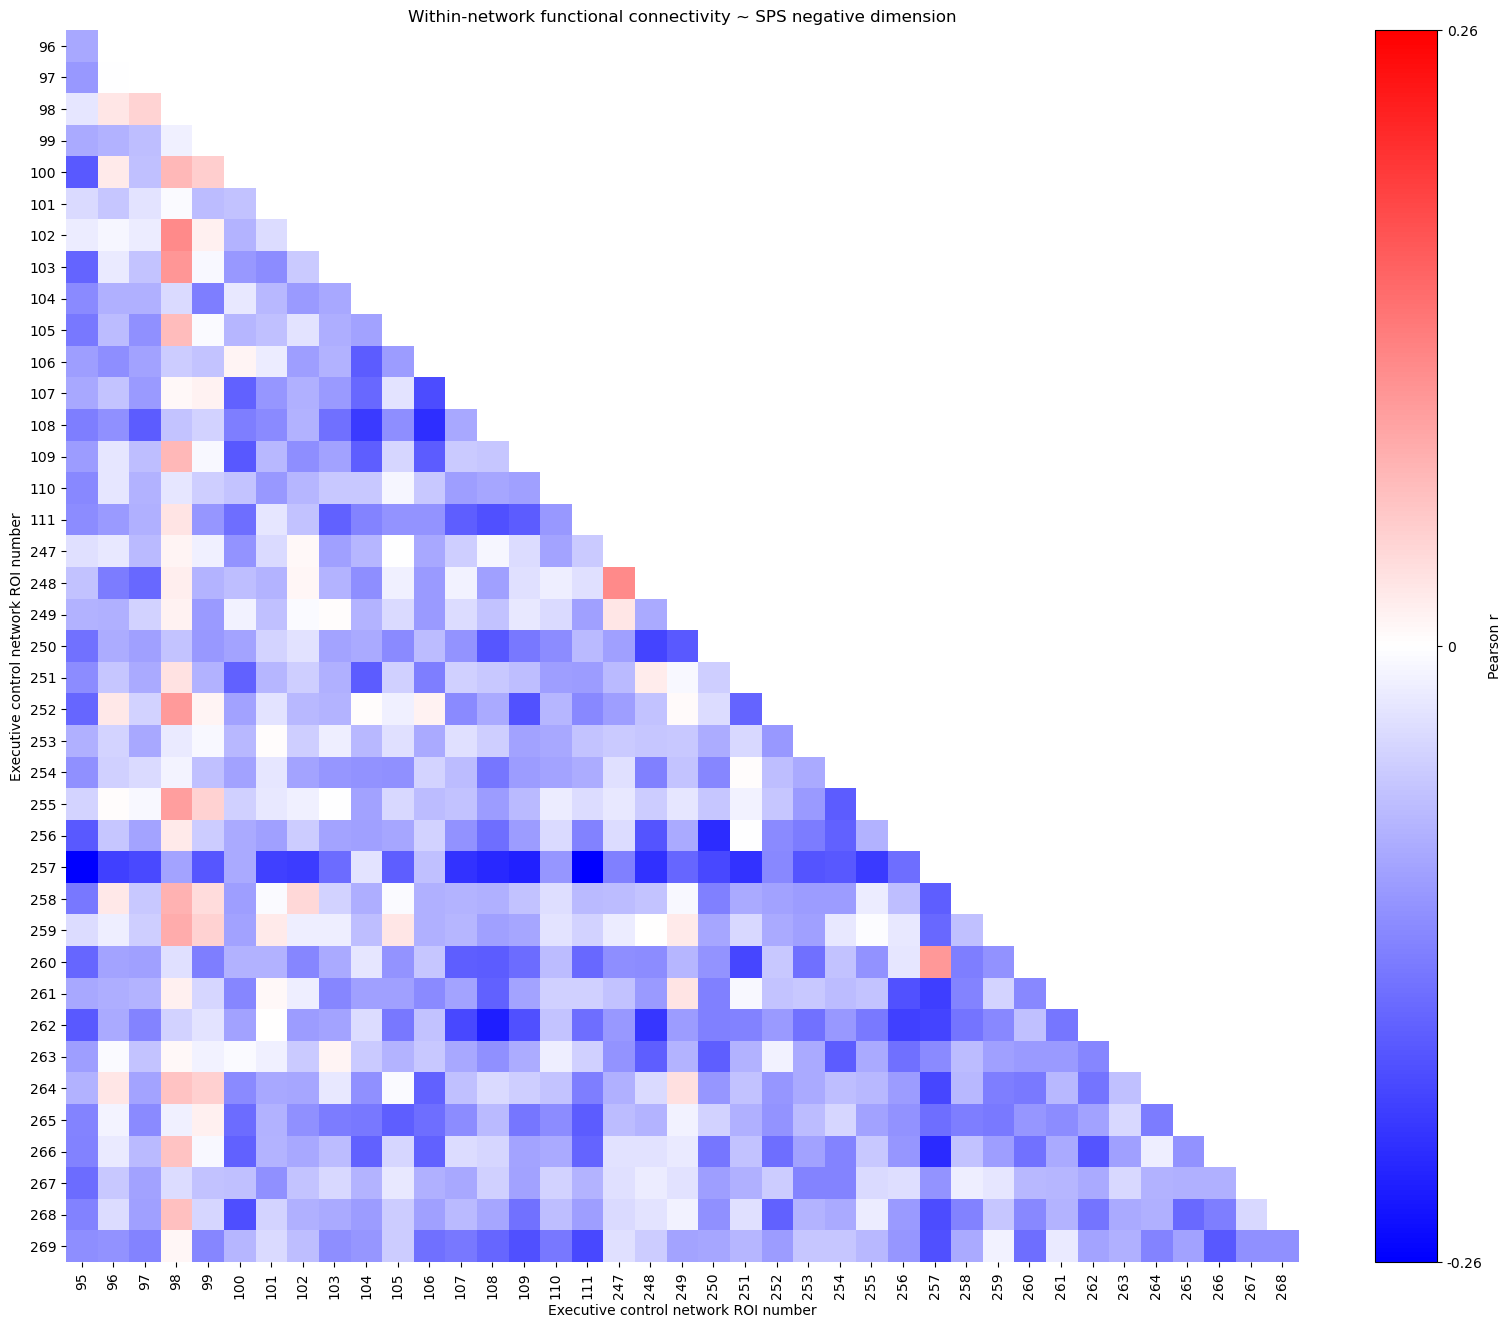

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("analysis/inter-subject_functional_connectivity/roi_node/results_isfc_roi_sps_within-control.csv")

# Pivot the DataFrame to create a matrix of node_a vs. node_b with pearson_r values
heatmap_data = data.pivot(index='node_a', columns='node_b', values='pearson_r')

# Transpose the DataFrame to get the lower triangle
heatmap_data = heatmap_data.transpose()

# Set the manual minimum and maximum 
manual_min = -0.26  
manual_max = 0.26 

# Create a heatmap
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed
plt.imshow(heatmap_data, cmap='bwr', interpolation='nearest', origin='upper', vmin=manual_min, vmax=manual_max)
cbar = plt.colorbar()
cbar.set_label('Pearson r', rotation=90)  # Add color bar label
cbar.set_ticks([manual_min, 0, manual_max])  # Set colorbar tick positions
cbar.set_ticklabels([manual_min, 0, manual_max])  # Set tick labels

plt.xlabel('Executive control network ROI number')
plt.ylabel('Executive control network ROI number')
plt.title('Within-network functional connectivity ~ SPS negative dimension')

# Show all tick marks
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

ax = plt.gca()
ax.set_frame_on(False)  # Remove the box around the plot

plt.show()


# Plot within- and between-network ISFC results 

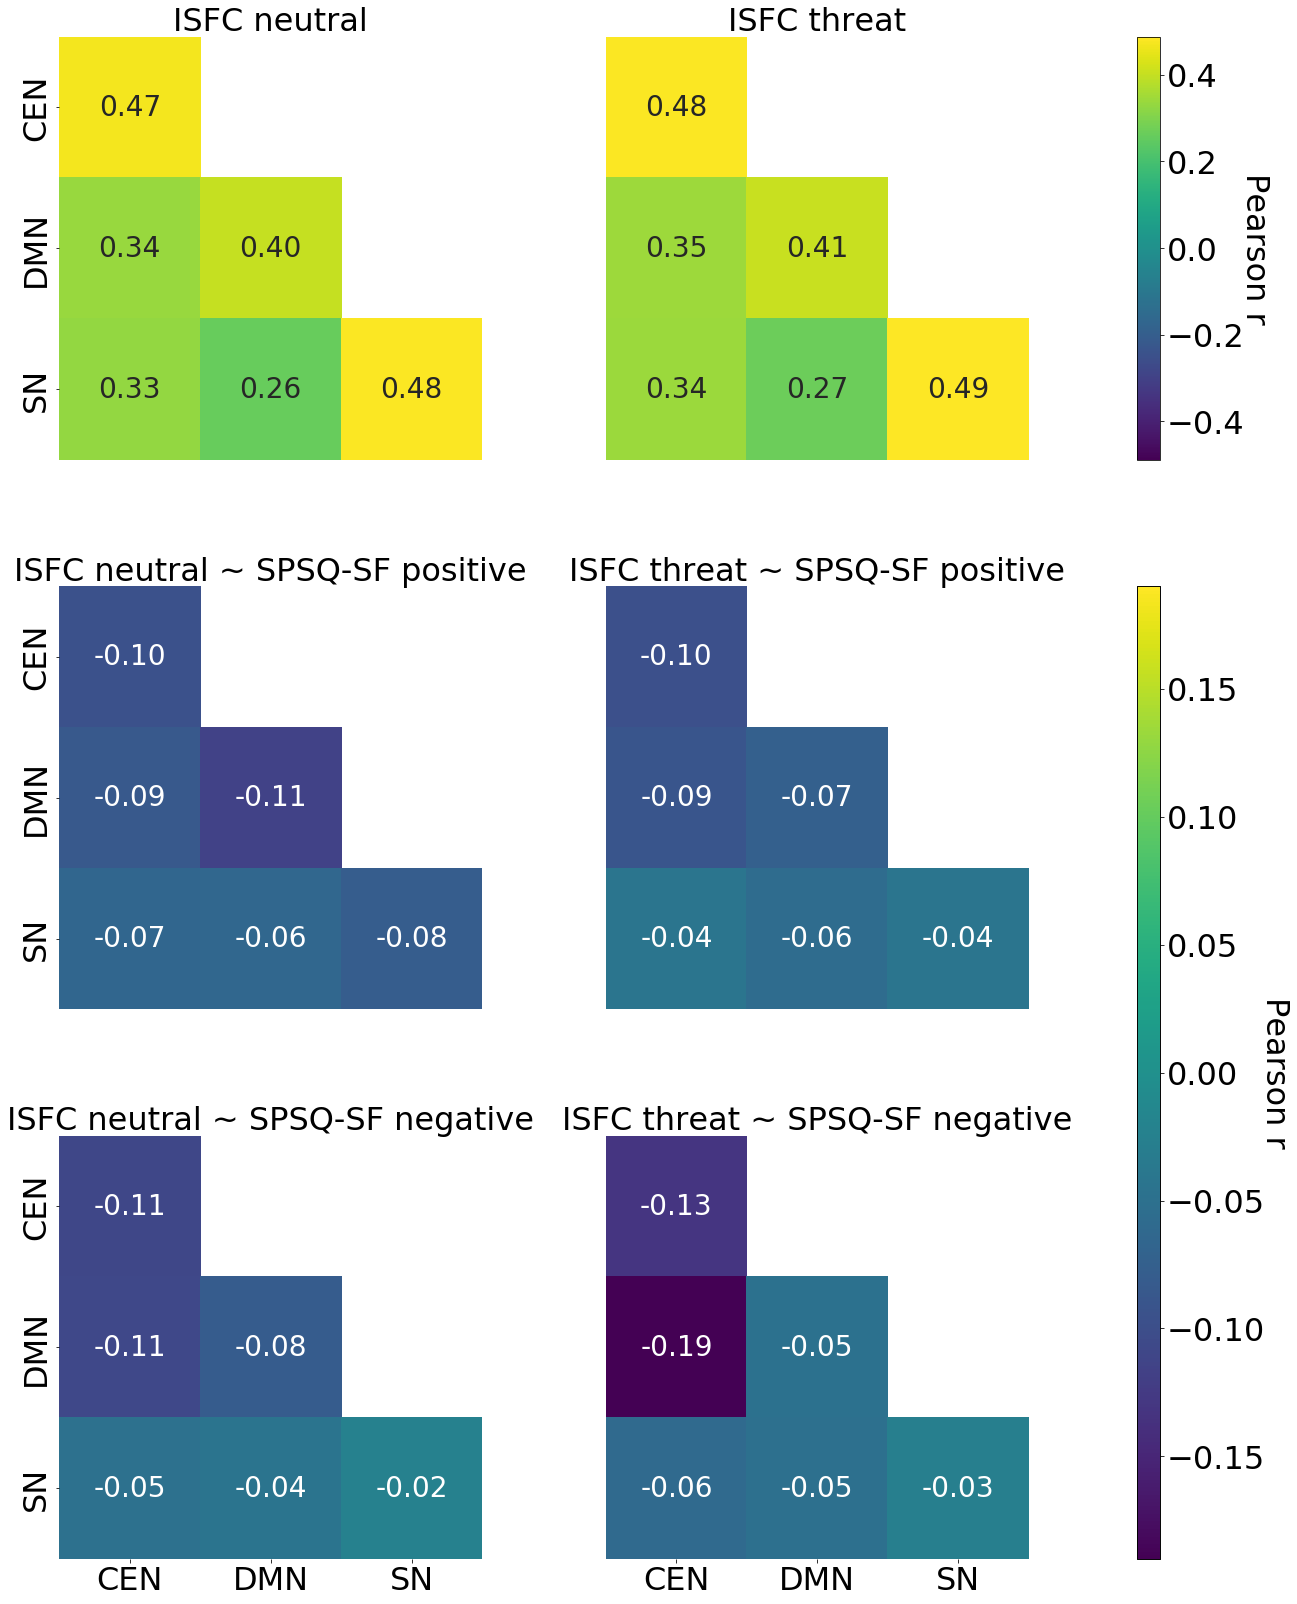

In [20]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

data_dir = 'analysis/inter-subject_functional_connectivity'
effects = ['main', 'positive', 'negative']
conditions = ['neutral', 'threat']

# Initialize variables to find the global min and max across all datasets for the first row
global_min_row1 = None
global_max_row1 = None

# Initialize variables to find the global min and max across all datasets for the second and third rows
global_min_row23 = None
global_max_row23 = None

# Iterate over the files to find the global min and max for the first row and the second and third rows separately
for effect in effects:
    for condition in conditions:
        file_path = os.path.join(data_dir, f'all_{effect}_{condition}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=0, index_col=0)
            local_min = df.values.min()
            local_max = df.values.max()
            if effect == 'main':  # First row
                if global_min_row1 is None or local_min < global_min_row1:
                    global_min_row1 = local_min
                if global_max_row1 is None or local_max > global_max_row1:
                    global_max_row1 = local_max
            else:  # Second and third rows
                if global_min_row23 is None or local_min < global_min_row23:
                    global_min_row23 = local_min
                if global_max_row23 is None or local_max > global_max_row23:
                    global_max_row23 = local_max

# Determine the absolute maximum for setting symmetric color scale centered at 0
max_scale_row1 = max(abs(global_min_row1), abs(global_max_row1))
max_scale_row23 = max(abs(global_min_row23), abs(global_max_row23))

# Adjust default font size for all plot elements
plt.rcParams.update({'font.size': 32})  # Increase the font size

# Create figure and gridspec layout
fig = plt.figure(figsize=(20, 28))
gs = GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.3, hspace=0.3)

# Custom titles for each heatmap
custom_titles = {
    'main_neutral': 'ISFC neutral',
    'main_threat': 'ISFC threat',
    'positive_neutral': 'ISFC neutral ~ SPSQ-SF positive',
    'positive_threat': 'ISFC threat ~ SPSQ-SF positive',
    'negative_neutral': 'ISFC neutral ~ SPSQ-SF negative',
    'negative_threat': 'ISFC threat ~ SPSQ-SF negative',
}

# Create heatmaps and color bars
for i in range(len(effects) * len(conditions)):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    effect = effects[i // len(conditions)]
    condition = conditions[i % len(conditions)]
    file_path = os.path.join(data_dir, f'all_{effect}_{condition}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, header=0, index_col=0)
        # Replace axis tick labels
        df.index = df.index.str.replace('salience', 'SN').str.replace('default', 'DMN').str.replace('control', 'CEN')
        df.columns = df.columns.str.replace('salience', 'SN').str.replace('default', 'DMN').str.replace('control', 'CEN')
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(df, dtype=bool), k=1)
        sns.heatmap(df, mask=mask, ax=ax, cmap='viridis', annot=True, fmt=".2f",
                    vmin=-max_scale_row1 if row == 0 else -max_scale_row23,
                    vmax=max_scale_row1 if row == 0 else max_scale_row23,
                    center=0, cbar=False, annot_kws={"size": 28}, square=True)
        # Use custom title
        custom_title_key = f"{effect}_{condition}"
        ax.set_title(custom_titles.get(custom_title_key, f"{effect} effect {condition} condition"), fontsize=32)  # Increase title font size
        # Center-align y-axis labels
        ax.set_yticklabels(ax.get_yticklabels(), va='center', fontsize=32)  # Increase y-axis label font size
        # Hide y-axis labels for the second column
        if col == 1:
            ax.set_yticklabels([])
            ax.set_yticks([])
        # Hide x-axis labels for the first two rows
        if row in [0, 1]:
            ax.set_xticklabels([])
            ax.set_xticks([])

    if row == 2:  # Third row
        cbar_ax = fig.add_subplot(gs[1:, 2])  # Colorbar for the second and third rows
        norm = plt.Normalize(vmin=-max_scale_row23, vmax=max_scale_row23)
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
        cbar.set_label('Pearson r', rotation=270, labelpad=25, fontsize=32)  # Increase colorbar label font size

# Colorbar for the first row
cbar_ax = fig.add_subplot(gs[0, 2])
norm = plt.Normalize(vmin=-max_scale_row1, vmax=max_scale_row1)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Pearson r', rotation=270, labelpad=25, fontsize=32)  # Increase colorbar label font size

# Save as PDF
output_dir = 'analysis/plots'
output_file = 'isfc_all_heatmaps.pdf'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, output_file), bbox_inches='tight')
plt.show()


Perform a Steiger test on threat vs. neutral to see if there is a condition modulation effect

## Steiger test to compare neutral vs. threat correlations

### Define function

In [42]:
"""
Functions for calculating the statistical significant differences between two dependent or independent correlation
coefficients.
The Fisher and Steiger method is adopted from the R package http://personality-project.org/r/html/paired.r.html
and is described in detail in the book 'Statistical Methods for Psychology'
The Zou method is adopted from http://seriousstats.wordpress.com/2012/02/05/comparing-correlations/
Credit goes to the authors of above mentioned packages!

Author: Philipp Singer (www.philippsinger.info)
"""

from __future__ import division

__author__ = 'psinger'

import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def rho_rxy_rxz(rxy, rxz, ryz):
    num = (ryz-1/2.*rxy*rxz)*(1-pow(rxy,2)-pow(rxz,2)-pow(ryz,2))+pow(ryz,3)
    den = (1 - pow(rxy,2)) * (1 - pow(rxz,2))
    return num/float(den)

def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(xz, n, conf_level=conf_level)[0]
        U2 = rz_ci(xz, n, conf_level=conf_level)[1]
        rho_r12_r13 = rho_rxy_rxz(xy, xz, yz)
        lower = xy - xz - pow((pow((xy - L1), 2) + pow((U2 - xz), 2) - 2 * rho_r12_r13 * (xy - L1) * (U2 - xz)), 0.5)
        upper = xy - xz + pow((pow((U1 - xy), 2) + pow((xz - L2), 2) - 2 * rho_r12_r13 * (U1 - xy) * (xz - L2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

#print(dependent_corr(.40, .50, .10, 103, method='steiger'))
#print(independent_corr(0.5 , 0.6, 103, 103, method='fisher'))

#print dependent_corr(.396, .179, .088, 200, method='zou')
#print independent_corr(.560, .588, 100, 353, method='zou')

### Run function

In [43]:
# Define paired correlation coefficients and sample size
correlation1 = -0.108  
correlation2 = -0.190
sample_size = 238  

test_statistic, p_value = dependent_corr(correlation1, correlation2, correlation2, sample_size, method='steiger')

print("Paired Correlation Comparison (Steiger):")
print(f"Correlation 1: {correlation1}")
print(f"Correlation 2: {correlation2}")
print(f"Test Statistic: {test_statistic}")
print(f"P-Value: {p_value}")
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

Paired Correlation Comparison (Steiger):
Correlation 1: -0.108
Correlation 2: -0.19
Test Statistic: 0.8309252981628148
P-Value: 0.4068592533180473
The difference is not statistically significant.


parcellation names: https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Yeo2011_fcMRI_clustering/1000subjects_reference/Yeo_JNeurophysiol11_SplitLabels/Yeo2011_7networks_N1000.split_components.glossary.csv

# ROI-level between-network ISFC

## Subset ISFCs to only ROIs in CEN and DMN

In [2]:
import os
import numpy as np
import pandas as pd

# Define your directory paths and filenames
data_dir = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat'
out_dir = f'{data_dir}/control-default'
between_dir = f'{out_dir}/between'
roi_network_file = 'analysis/atlas_schaefer/label_network.csv'

# Load the ROI-to-network mapping
roi_network_df = pd.read_csv(roi_network_file)

# Identify ROIs belonging to the control and default networks
control_network_rois = roi_network_df[roi_network_df['network'] == 'control']['node'].tolist()
default_network_rois = roi_network_df[roi_network_df['network'] == 'default']['node'].tolist()

# Create the output directories if they don't exist
os.makedirs(out_dir, exist_ok=True)
os.makedirs(between_dir, exist_ok=True)

# Loop through subject files
for subject_file in os.listdir(data_dir):
    if subject_file.endswith('.csv'):  # Assuming your data files are in CSV format
        subject_data = pd.read_csv(os.path.join(data_dir, subject_file), header=0, index_col=0)

        # Remove the '.0' from column names
        subject_data.columns = [int(col.split('.')[0]) for col in subject_data.columns]

        # Subset the original 300x300 matrix based on control and default network ROIs
        control_default_data = subject_data.loc[control_network_rois + default_network_rois, control_network_rois + default_network_rois]

        # Create a new DataFrame for the "between" output
        between_data = control_default_data.copy()

        # Loop through each ROI and disconnect ROIs in the same network
        for roi in control_default_data.columns:
            if roi in control_network_rois:
                between_data.loc[roi, control_network_rois] = 0
            if roi in default_network_rois:
                between_data.loc[roi, default_network_rois] = 0

        # Save the selected connectivity matrix in the out_dir
        output_filename = os.path.join(out_dir, subject_file)
        control_default_data.to_csv(output_filename)

        # Save the modified matrix in the between_dir
        between_output_filename = os.path.join(between_dir, subject_file)
        between_data.to_csv(between_output_filename)

# After creating the "between" files, replace '0.0' with 'NA' in those files
for between_file in os.listdir(between_dir):
    if between_file.endswith('.csv'):
        between_data = pd.read_csv(os.path.join(between_dir, between_file), header=0, index_col=0)
        between_data = between_data.replace(0.0, 'NA')
        between_data.to_csv(os.path.join(between_dir, between_file))

print("Process completed. Connectivity matrices for control and default networks have been saved to", out_dir)
print("Modified matrices in the 'between' directory with '0.0' replaced by 'NA' have been saved.")

Process completed. Connectivity matrices for control and default networks have been saved to analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default
Modified matrices in the 'between' directory with '0.0' replaced by 'NA' have been saved.


## Subset further to be CEN ROIs x DMN ROIs

In [3]:
import os
import pandas as pd

# Set the input and output directories
data_dir = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between'
out_dir = f'{data_dir}/subset'

# Create the output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

# List all CSV files in the data directory
csv_files = [file for file in os.listdir(data_dir) if file.endswith('.csv')]

# Loop through each CSV file and process it
for csv_file in csv_files:
    # Construct the full path to the CSV file
    input_csv = os.path.join(data_dir, csv_file)
    
    # Read the CSV file with header=0 and index_col=0
    df = pd.read_csv(input_csv, header=0, index_col=0)
    
    # Remove the first 40 rows and keep the first 40 columns
    df = df.iloc[40:, :40]
    
    # Construct the full path to the output CSV file
    output_csv = os.path.join(out_dir, csv_file)
    
    # Save the processed DataFrame to the output CSV file
    df.to_csv(output_csv)

    print(f"Processed: {csv_file} -> {output_csv}")

Processed: subject-0001_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0001_isfc.csv
Processed: subject-0003_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0003_isfc.csv
Processed: subject-0004_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0004_isfc.csv
Processed: subject-0005_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0005_isfc.csv
Processed: subject-0006_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0006_isfc.csv
Processed: subject-0007_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0007_isfc.csv
Processed: subject-0008_isfc.csv -> analysis/inter-subject_functional_connec

Processed: subject-0065_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0065_isfc.csv
Processed: subject-0066_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0066_isfc.csv
Processed: subject-0067_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0067_isfc.csv
Processed: subject-0068_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0068_isfc.csv
Processed: subject-0069_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0069_isfc.csv
Processed: subject-0070_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0070_isfc.csv
Processed: subject-0071_isfc.csv -> analysis/inter-subject_functional_connec

Processed: subject-0125_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0125_isfc.csv
Processed: subject-0126_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0126_isfc.csv
Processed: subject-0127_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0127_isfc.csv
Processed: subject-0128_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0128_isfc.csv
Processed: subject-0129_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0129_isfc.csv
Processed: subject-0130_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0130_isfc.csv
Processed: subject-0131_isfc.csv -> analysis/inter-subject_functional_connec

Processed: subject-0180_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0180_isfc.csv
Processed: subject-0181_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0181_isfc.csv
Processed: subject-0182_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0182_isfc.csv
Processed: subject-0183_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0183_isfc.csv
Processed: subject-0184_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0184_isfc.csv
Processed: subject-0185_isfc.csv -> analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/subject-0185_isfc.csv
Processed: subject-0186_isfc.csv -> analysis/inter-subject_functional_connec

## Vectorize

In [4]:
import os
import pandas as pd

# Set the directory paths
data_dir = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset'
out_dir = f'{data_dir}/vectorized'  

# Create the output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

# List all the CSV files in the data_dir
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Iterate through each CSV file, read and vectorize it, then save to the out_dir
for csv_file in csv_files:
    # Construct the input file path
    input_file_path = os.path.join(data_dir, csv_file)
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_file_path, header=0, index_col=0)
    
    # Vectorize the DataFrame (convert it into a 1D array)
    vectorized_df = df.values.flatten()
    
    # Create a list with combined "column-row" information
    combined_info = [f'{col}-{row}' for col in df.columns for row in df.index]
    
    # Create a new DataFrame with 'Column-Row' and 'Vectorized Data' columns
    info_df = pd.DataFrame({
        'control-default': combined_info,
        'connectivity': vectorized_df
    })
    
    # Create the output file path
    output_file_path = os.path.join(out_dir, csv_file)
    
    # Save the vectorized data with combined information to a new CSV file in the out_dir
    info_df.to_csv(output_file_path, index=False)

print("Vectorization and saving with combined column-row and vectorized data completed.")

Vectorization and saving with combined column-row and vectorized data completed.


## Concatenate across subjects

In [5]:
import os
import pandas as pd

data_dir = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/vectorized'
output_dir = f'{data_dir}/concatenated'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

subject_matrices = [file for file in os.listdir(data_dir) if file.endswith('.csv')]

all_data = []

for subject_matrix_file in subject_matrices:
    input_file = os.path.join(data_dir, subject_matrix_file)

    # Load the CSV file as a DataFrame
    df = pd.read_csv(input_file, header=0, index_col=1)

    # Transpose the DataFrame
    df = df.T

    # Extract the subject ID from the filename (between the first and second "_")
    subject_id = subject_matrix_file.split('_')[0]

    # Rename the subject_id column to "subject"
    df = df.rename(columns={'subject_id': 'subject'})

    # Create a new column for subject and insert the extracted subject ID
    df.insert(0, 'subject', subject_id)

    all_data.append(df)

# Concatenate all DataFrames into one for the current condition
concatenated_df = pd.concat(all_data, ignore_index=True)

# Save the concatenated data to a single CSV file for the current condition
output_file = os.path.join(output_dir, f'concatenated_threat_data.csv')
concatenated_df.to_csv(output_file, index=False)

print(f'Saved concatenated data to {output_file}')

Saved concatenated data to analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/vectorized/concatenated/concatenated_threat_data.csv


## Merge with SPS data

In [6]:
import os
import pandas as pd

# Load the concatenated data
concatenated_data_file = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/vectorized/concatenated/concatenated_threat_data.csv'
concatenated_df = pd.read_csv(concatenated_data_file, header=0)

# Load the SPSQ-24 data
spsq_data_file = 'analysis/SPSQ-24_all.csv'
spsq_df = pd.read_csv(spsq_data_file, header=0)

# Merge the concatenated data with the SPSQ-24 data based on the "subject" column
merged_df = pd.merge(concatenated_df, spsq_df, on='subject', how='inner')

# Determine the output directory based on the location of the concatenated data file
output_dir = os.path.dirname(concatenated_data_file)

# Save the merged data to a new CSV file in the same directory as the concatenated data
output_file = os.path.join(output_dir, f'merged_all_data.csv')
merged_df.to_csv(output_file, index=False)

print(f'Saved merged data to {output_file}')

Saved merged data to analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/vectorized/concatenated/merged_all_data.csv


## Between-network ROI-specific ISFC heatmap of correlations

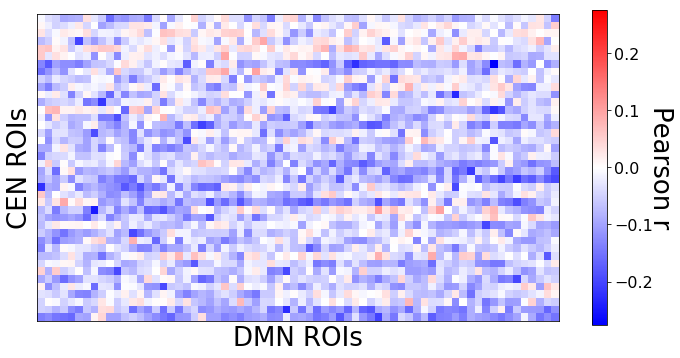

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("analysis/inter-subject_functional_connectivity/z_roi_node/results_isfc_roi_sps_100124.csv")

# Pivot the DataFrame to create a matrix of node_a vs. node_b with pearson_r values
heatmap_data = data.pivot(index='node_a', columns='node_b', values='pearson_r')

# Determine the maximum absolute value in the data
max_abs_value = max(abs(heatmap_data.values.min()), abs(heatmap_data.values.max()))

# Font size
plt.rc('font', size=26)  # default text sizes
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=26)

# Create a heatmap
plt.figure(figsize=(11.69, 8.27))  # landscape A4 size in inches
plt.imshow(heatmap_data, cmap='bwr', interpolation='nearest', origin='upper', vmin=-max_abs_value, vmax=max_abs_value)

# Remove ticks and tick labels for both axes
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.xticks([])  # Hide x-axis ticks and labels
plt.yticks([])  # Hide y-axis ticks and labels

# Make the colorbar the same length as the y-axis
cbar = plt.colorbar(shrink=0.7)  # Adjust the shrink parameter as needed to make the colorbar shorter
cbar.set_label('Pearson r', rotation=270, labelpad=20)

# Make the colorbar tick font larger
cbar.ax.tick_params(labelsize=16)  # Adjust the labelsize as needed

plt.xlabel('DMN ROIs')
plt.ylabel('CEN ROIs')

# Save the figure as a PDF
plt.savefig('analysis/plots/between_rois_isfc_heatmap.pdf', format='pdf', bbox_inches='tight')

plt.show()


## Correlate ISFC at the ROI level to SPS

In [9]:
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# Create empty lists to store the results and p-values
results = []
p_values = []

# Load your CSV file into a DataFrame
data_path = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/vectorized/concatenated/merged_all_data.csv'
df = pd.read_csv(data_path)

# Fill blank cells with 'NA'
#df = df.fillna('NA')

# Print the first few lines of the DataFrame for debugging
#print(df.head())

# Create a list of column names with hyphens
columns_with_hyphens = [col for col in df.columns if '-' in col]

# Print all the column names with hyphens in 'conn' for debugging
#print("All column names with hyphens in 'conn':", columns_with_hyphens)

# Loop through the columns with hyphens for 'conn'
for conn in columns_with_hyphens:
    # Check if the column contains at least one non-'NA' value
    #if 'NA' in df[conn].values:
        #print(f"Skipping column '{conn}' because it contains 'NA' values.")
        #continue  # Skip the column
    for dim in ['SPSQ_neg']:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(df[conn].astype(float), df[dim].astype(float))

        # Store the p-value for FDR correction
        p_values.append(p_value)

        # Append the results to the list
        results.append({'connectivity': conn, 'dimension': dim, 'pearson_r': correlation, 'p': p_value})

# Apply FDR correction using fdrcorrection
rejected, p_fdr = fdrcorrection(p_values, alpha=0.05)

# Assign FDR-corrected p-values to the results
for i, result in enumerate(results):
    result['p_fdr'] = p_fdr[i]

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_df.to_csv('analysis/inter-subject_functional_connectivity/z_roi_node/results_isfc_roi_sps.csv', index=False)

## Scatterplot of individual ROI-ROI ISFC vs. SPSQ-SF negative dimension correlations 

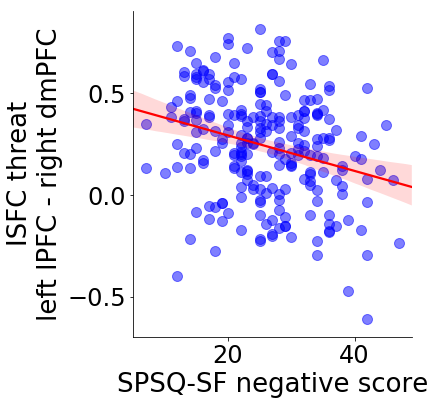

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a DataFrame
file_path = 'analysis/inter-subject_functional_connectivity/z_roi_node/threat/control-default/between/subset/vectorized/concatenated/merged_all_data.csv'
df = pd.read_csv(file_path)

# Specify the columns for x and y
x_column = 'SPSQ_neg'
y_column = '101-291'

# Set the figure size
plt.figure(figsize=(5, 6))

# Create a scatterplot with outlined points, filled color, alpha, and larger size
plt.scatter(df[x_column], df[y_column], color='blue', alpha=0.5, s=100) #edgecolors='#000000', linewidth=1, 

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Increase font size for ticks
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Add Pearson regression line
sns.regplot(x=x_column, y=y_column, data=df, scatter=False, color='red', line_kws={'label':'Pearson Regression'})

# Add labels
plt.xlabel("SPSQ-SF negative score", fontsize=26) 
plt.ylabel("ISFC threat\nleft lPFC - right dmPFC", fontsize=26) 

# Save the figure to a PDF file
plt.savefig('analysis/plots/isfc_roi-roi_SPS_scatterplot.pdf', format='pdf', bbox_inches='tight')

plt.show()
